In [1]:
import pennylane as qml
from pennylane import numpy as np
from scipy.stats import unitary_group
import numpy.random as rnd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Generate random state
def random_state(num_qubits, seed):
  rs = unitary_group.rvs(dim=2**num_qubits, random_state=rnd.default_rng(seed))
  return rs[0]

def random_observable(num_qubits, seed):
  real, img = rnd.random((2, 2**num_qubits, 2**num_qubits))
  
  real = real+real.T
  img = img - img.T
  
  H = real + 1j*img
  return H

In [3]:
from jax.config import config

config.update("jax_enable_x64", True)
import jax
from jax import numpy as np
import pennylane as qml

def make_cost(N, seed):
  dev = qml.device("default.qubit", wires=N)
  print(dev.wires)

  @jax.jit
  @qml.qnode(dev, interface="jax")
  def cost(x):
    qml.QubitStateVector(random_state(N, seed), wires=dev.wires)
    for wire in dev.wires:
      qml.RZ(x, wires=wire, id="x")
    return qml.expval(qml.Hermitian(random_observable(N, seed), wires=dev.wires))
  return cost

In [4]:
# gatehr the cost functions that we wish to analyse
Ns = [1,2,4,8]
seed = 1000

all_costs = []
for n in Ns:
  all_costs.append(make_cost(n, seed))

<Wires = [0]>
<Wires = [0, 1]>
<Wires = [0, 1, 2, 3]>
<Wires = [0, 1, 2, 3, 4, 5, 6, 7]>


In [5]:
num_points = 60
X_range = np.linspace(-np.pi, np.pi, num_points)
exp_vals = []
for cost in all_costs:
  exp_vals.append([cost(x) for x in X_range])

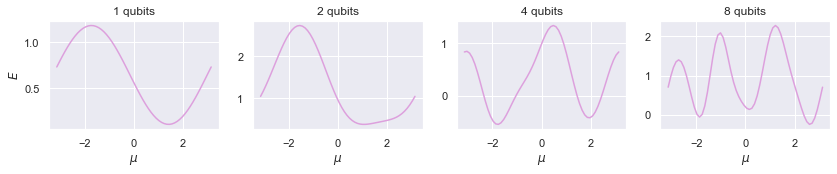

In [6]:
fig, axs = plt.subplots(1, len(Ns), figsize=(14, 2))

for ax, N, E in zip(axs, Ns, exp_vals):
    # Plot cost function evaluations
    ax.plot(X_range, E, color="plum")
    # Axis and plot labels
    ax.set_title(f"{N} qubits")
    ax.set_xlabel("$\mu$")

_ = axs[0].set_ylabel("$E$")
plt.savefig("images/fourier.svg")
plt.show()

In [7]:
np.linalg.eig(random_observable(1, 300))

[DeviceArray([ 1.68051184-1.53660210e-17j, -0.39101536+4.31215966e-17j],            dtype=complex128),
 DeviceArray([[ 0.74907827+0.j        , -0.62577706-0.21745072j],
              [ 0.62577706-0.21745072j,  0.74907827+0.j        ]],            dtype=complex128)]

## Research Question 1
### How good is learning when we use the 2 term param shift rule?

**Custom gate**
[How to create custom gates](https://pennylane.ai/blog/2021/05/how-to-add-custom-gates-and-templates-to-pennylane/)

In [8]:
from pennylane.operation import Operation

class IncognitoGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = "R"
    
    @staticmethod
    def decomposition(theta, wires):
        return [qml.PauliRot(theta, 'XX', wires=wires)]

In [9]:
dev2 = qml.dev

AttributeError: module pennylane has no attribute dev